# ELABORATION OF THE LATENCIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Imported the libraries and collected the data, I will proceed to anaylse these times in different ways. Firstly I want to look at the situation with a number of processes equal to the number of cores available in the two nodes (256 in total for the EPYCs and 48 in total for the THINs). Fixed the number of processes, I want to analyse the execution times for different sizes of the message for both of the collective operations and for both the type of node.

# MAXIMUM NUM OF PROCESSES

Before starting, we define the names of two files where we have deposited the point to point latency data both for the THIN nodes and the EPYC nodes. I want to stress that this data were collected mapping by node and reserving completely the two nodes, as for the other recordings. 

In [2]:
naive_thin_files = [ #Latency of the P2P communication on THIN mapping by node
    "naive/naive_THIN.csv",
]

naive_epyc_files = [ #Latency of the P2P communication on EPYC mapping by node
    "naive/naive_EPYC.csv",
]

# bcast

Let's start looking to the result of the "bcast" operation. Firstly, I explicit again the names to simplify the import of the files then.

In [3]:
bcast_epyc_files = [ #File names for the EPYC nodes
    "bcast/EPYC/Size/base.csv", #base line (no specifications)
    "bcast/EPYC/Size/pipeline.csv", #pipeline algorithm
    "bcast/EPYC/Size/binomial.csv", #binomial algorithm
    "bcast/EPYC/Size/ring.csv" #scatter all gather ring (called "ring" from now on)
]

bcast_thin_files = [ #File names for the THIN nodes
    "bcast/THIN/Size/base.csv",
    "bcast/THIN/Size/pipeline.csv",
    "bcast/THIN/Size/binomial.csv",
    "bcast/THIN/Size/ring.csv"
]

### EPYC

I will look at first to the EPYC results. Before doing this, I need to also import the P2P latency on EPYC. The times recorded were only for a comunication between 2 processes but now I want to use them for the naive approach of bcast. The naive approach is to simply pass the message with single communication from the starting node to each one of the others. Therefore, I have to multiply the latency data by 255 (256 processes -> 255 communications).

In [4]:
file = (pd.read_csv(naive_epyc_files[0],delimiter=",",header=None).to_numpy())*255.0 #Import P2P latency and multiply for the number of communication
naive_traj_EPYC = np.zeros((21,2),dtype=float) #Prepare traj array

#We have repeated the measure 20 times so we can compute the mean latency and the mean STD for each traj point.
for j in range(np.shape(file)[1]):
    naive_traj_EPYC[j,0] = np.mean(file[j,1:])
    naive_traj_EPYC[j,1] = np.std(file[j,1:])

Now I can import the other files for the base line and the other algorithms for the bcast obtained on the EPYC nodes with 256 processes

In [5]:
x = [] #The x is the size of the message passed

trajs = np.zeros((4,21,2),dtype=float) #Trajs is the tensor of the 4 trajectories (base,pipeline,binomial and ring)

for i in range(len(bcast_epyc_files)):
    #Each file is imported and converted to numpy format
    file = pd.read_csv(bcast_epyc_files[i],delimiter=",",header=None)
    file = file.to_numpy()
    
    #x is defined each time for simplicity. In each file the first columns contain the message sizes
    #thus it will be simply rewrited with the same values 4 times.
    x = file[:,0]

    #For each message size the momentums are computed
    for j in range(np.shape(file)[1]):
        trajs[i,j,0] = np.mean(file[j,1:]) #the mean
        trajs[i,j,1] = np.std(file[j,1:]) #the std

Finally I can plot the mean times for each size for each algorithms + base line and naive approach

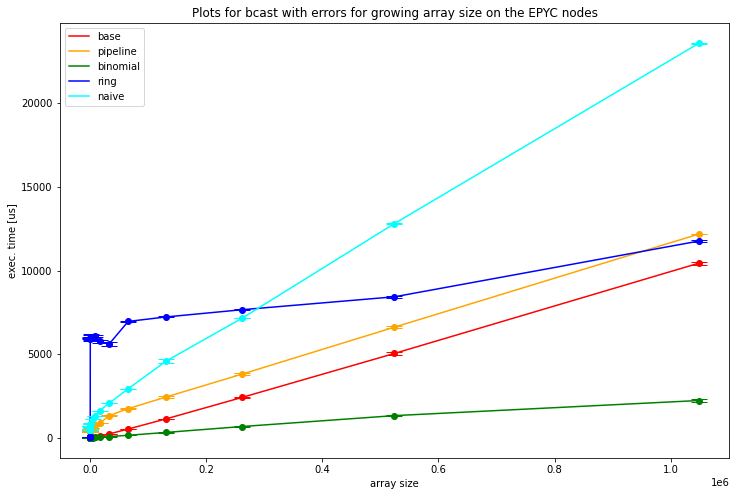

In [6]:
plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for growing array size on the EPYC nodes")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(x,trajs[0,:,0],color='red',label="base")
plt.plot(x,trajs[1,:,0],color='orange',label="pipeline")
plt.plot(x,trajs[2,:,0],color='green',label="binomial")
plt.plot(x,trajs[3,:,0],color='blue',label="ring")
plt.plot(x,naive_traj_EPYC[:,0],color='aqua',label="naive")
plt.errorbar(x,trajs[0,:,0],yerr=trajs[0,:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,trajs[1,:,0],yerr=trajs[1,:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,trajs[2,:,0],yerr=trajs[2,:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,trajs[3,:,0],yerr=trajs[3,:,1],fmt='o',color='blue',capsize=8)
plt.errorbar(x,naive_traj_EPYC[:,0],yerr=naive_traj_EPYC[:,1],fmt='o',color='aqua',capsize=8)
plt.legend(loc="upper left")

Looking to the plot, it is possible to observe some things:
    
- Fortunately, the naive approach is generally worse than all the others, so the processings and the structure of the other methods are paying.
- The binomial algorithm seems the best performer among the possibilities with also a lower scaling than the others.
- Pipeline and the base line have very similar behaviour, but the second have better times than the first. The distance between the two remains constant for big sizes. 
- The ring algorithm has quite a strange behaviour. For small sizes, the times are drammaticaly higher than the others and the method is performing way worse than all the others, naive inclueded. However, this algorithm has a very good scalability and, for an increasing size, the times are growing very slowly in a way very similar to the binomial one. Unfortunately, the higher starting point produces comparable performances for the biggest size only with the pipeline algorithm and the base line. In the other cases, the ring performances are worse than the performances of the red and orange. 
- At last, the deviations are very small, therefore there are no doubt about the results.

On the other hand, the plot above has an important flaw: it is very difficult to understand the behaviour for the small sizes. To observe better this region, I can produce again the plot in a log10-log10 scale. However, the stds cannot be reported this time because the logarithm of the std in most of the cases will be negative and they have no sense.

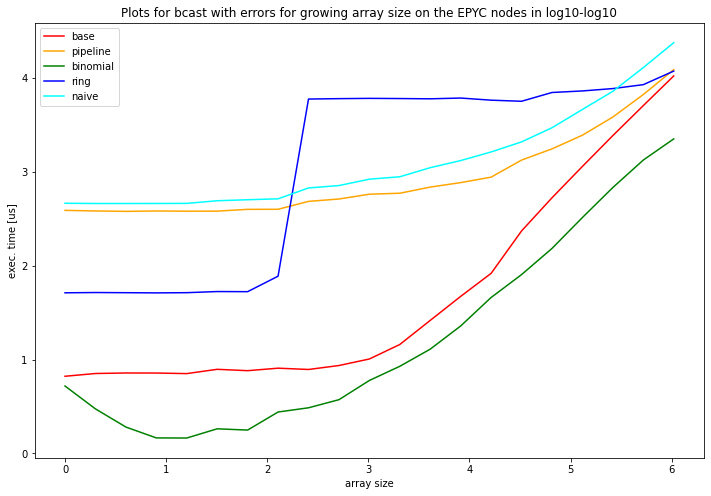

In [7]:
plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for growing array size on the EPYC nodes in log10-log10")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(np.log10(x),np.log10(trajs[0,:,0]),color='red',label="base")
plt.plot(np.log10(x),np.log10(trajs[1,:,0]),color='orange',label="pipeline")
plt.plot(np.log10(x),np.log10(trajs[2,:,0]),color='green',label="binomial")
plt.plot(np.log10(x),np.log10(trajs[3,:,0]),color='blue',label="ring")
plt.plot(np.log10(x),np.log10(naive_traj_EPYC[:,0]),color='aqua',label="naive")
plt.legend(loc="upper left")

The situation for small sized is very different!

- Firstly, I have that the ring algorithms for smaller sizes has far better performances being better than the naive and the pipeline. However, with these array sizes around the hundred of chars, there is a sudden huge jump in the times.
- Pipeline for small sizes performs almost as the naive approach. This tells us that in such situations to transfer with P2P communications is almost as using the algorithm.
- I can finally look to the origin of the distance between the base line and the binomial. In fact, the two trajectories start very near, however, the binomial algorithm is able to even reduce the computation time for bigger sizes. This difference due to this shrinking is the source of the almost fixed distance for bigger sizes between the base line and the binomial algorithm.

### THIN

Now I will repeat these tests on the THIN nodes. As before, I will firstly import the P2P latency to obtain the naive approach. For the THIN nodes, there are 48 cores, thus the operation will be measure for 48 processes.

In [8]:
file = (pd.read_csv(naive_thin_files[0],delimiter=",",header=None).to_numpy())*47.0 #Import P2P latency and multiply for the number of communication
naive_traj_THIN = np.zeros((21,2),dtype=float)  #Prepare traj array

#We have repeated the measure 20 times so we can compute the mean latency and the mean STD for each traj point.
for j in range(np.shape(file)[1]):
    naive_traj_THIN[j,0] = np.mean(file[j,1:])
    naive_traj_THIN[j,1] = np.std(file[j,1:])

Now, I can import the other files for the base line and the other algorithms for bcast obtained on the THIN nodes with 48 processes

In [9]:
x = [] #The x is the size of the message passed

#Trajs is the tensor of the 4 trajectories (base,pipeline,binomial and ring)
trajs = np.zeros((4,21,2),dtype=float)

for i in range(len(bcast_thin_files)):
    #Each file is imported and converted to numpy format
    file = pd.read_csv(bcast_thin_files[i],delimiter=",",header=None)
    file = file.to_numpy()
    
    #x is defined each time for simplicity. In each file the first columns contain the message sizes
    #thus it will be simply rewrited with the same values 4 times.
    x = file[:,0]

    #For each message size the momentums are computed
    for j in range(np.shape(file)[1]):
        trajs[i,j,0] = np.mean(file[j,1:]) #the mean
        trajs[i,j,1] = np.std(file[j,1:]) #the std

Finally, I can plot the mean times for each size for each algorithms + base line and naive approach

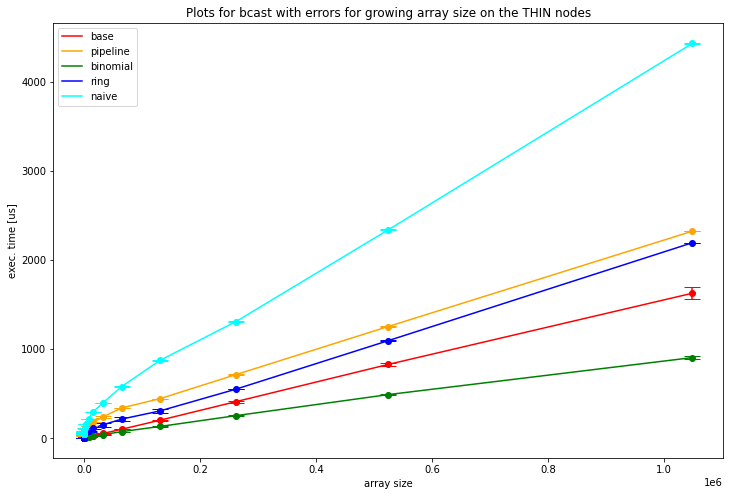

In [10]:
plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for growing array size on the THIN nodes")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(x,trajs[0,:,0],color='red',label="base")
plt.plot(x,trajs[1,:,0],color='orange',label="pipeline")
plt.plot(x,trajs[2,:,0],color='green',label="binomial")
plt.plot(x,trajs[3,:,0],color='blue',label="ring")
plt.plot(x,naive_traj_THIN[:,0],color="aqua",label="naive")
plt.errorbar(x,trajs[0,:,0],yerr=trajs[0,:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,trajs[1,:,0],yerr=trajs[1,:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,trajs[2,:,0],yerr=trajs[2,:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,trajs[3,:,0],yerr=trajs[3,:,1],fmt='o',color='blue',capsize=8)
plt.errorbar(x,naive_traj_THIN[:,0],yerr=naive_traj_THIN[:,1],fmt='o',color='aqua',capsize=8)
plt.legend(loc="upper left")

The situation here is far more tidy than the case for EPYC nodes:

- The naive approach is the worst performer and with a notable distance from the other algorithms. 
- The ring performances and the pipeline performances are comparable, even if, the ring has always a bit smaller times than the pipeline. At least, this is what observable for the big sizes.
- Again, the binomial algorithm is the best both in term of times and in term of scalability, while the base line is now an intermediate situation between the binomial and the ring approach.

To sum up, for big sizes of the passed message, I have an important and tidy characterisation between the trajectories with some similarities and some differences with the EPYC case. However, I can also take a look to the lower sizes passing into log10-log10 scale. As for the EPYC, I cannot show here the deviations because the logarithm transforms some of them into negative values.

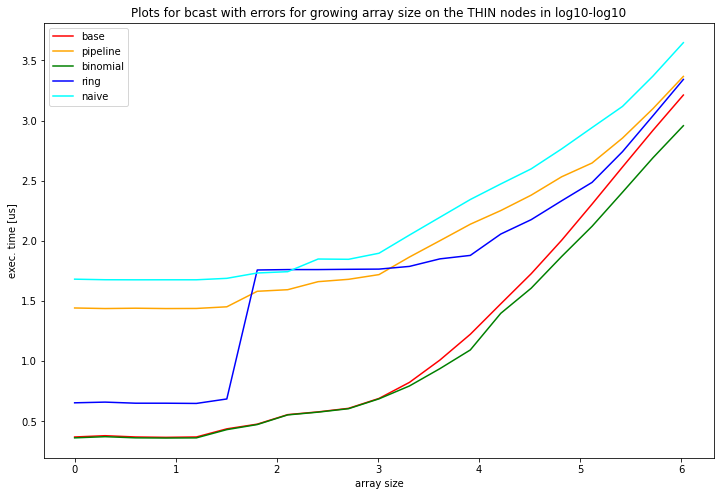

In [11]:
plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for growing array size on the THIN nodes in log10-log10")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(np.log10(x),np.log10(trajs[0,:,0]),color='red',label="base")
plt.plot(np.log10(x),np.log10(trajs[1,:,0]),color='orange',label="pipeline")
plt.plot(np.log10(x),np.log10(trajs[2,:,0]),color='green',label="binomial")
plt.plot(np.log10(x),np.log10(trajs[3,:,0]),color='blue',label="ring")
plt.plot(np.log10(x),np.log10(naive_traj_THIN[:,0]),color="aqua",label="naive")
plt.legend(loc="upper left")

It is immediately notable that the situation for lower sizes has no radical differences:

- The binomial and the base line are almost coincident but around 1000 elements in the char array they start to have a slow but steady separation.
- Pipeline and naive are conserving their behaviour and relationship.
- I can now notice that the ring algorithm presents again a step, but, this time is far smaller and this produces performances worse than the naive only in a particular situation. This smaller step allows then, thanks to the lower scalability of the ring, to reach an intermediate position among the trajectories.

# gather

Let's move on to the gather collective operation and perform again the same type of tests, both on the EPYC and THIN nodes. I can start putting in arrays the names of the files.

In [12]:
gather_epyc_files = [ #File names for the EPYC nodes
    "gather/EPYC/Size/base.csv", #base line (no specifications)
    "gather/EPYC/Size/linear.csv", #linear algorithm
    "gather/EPYC/Size/binomial.csv", #binomial algorithm
    "gather/EPYC/Size/sync.csv" #linear with synchronisation algorithm (called "sync" now on)
]

gather_thin_files = [  #File names for the THIN nodes
    "gather/THIN/Size/base.csv",
    "gather/THIN/Size/linear.csv",
    "gather/THIN/Size/binomial.csv",
    "gather/THIN/Size/sync.csv"
]

### EPYC

Again, I will look at first to the EPYC results. This time, it is not necessary to import the P2P latencies again because there were imported before already and they will be used in the same form. I can move directly to the import of the other trajectories.

In [13]:
#The x is the same as before because osu_gather tests the same sizes
x = []

#Trajs is the tensor of the 4 trajectories (base,linear,binomial and sync)
trajs = np.zeros((4,21,2),dtype=float)

for i in range(len(gather_epyc_files)):
    #Each file is imported and converted to numpy format
    file = pd.read_csv(gather_epyc_files[i],delimiter=",",header=None)
    file = file.to_numpy()
    
    #As before x is redefined at every iteration for simplicity
    x = file[:,0]

    #For each message size the momentums are computed
    for j in range(np.shape(file)[1]):
        trajs[i,j,0] = np.mean(file[j,1:])
        trajs[i,j,1] = np.std(file[j,1:])

Finally, I can plot the mean times for each size for each algorithms + base linea and naive approach

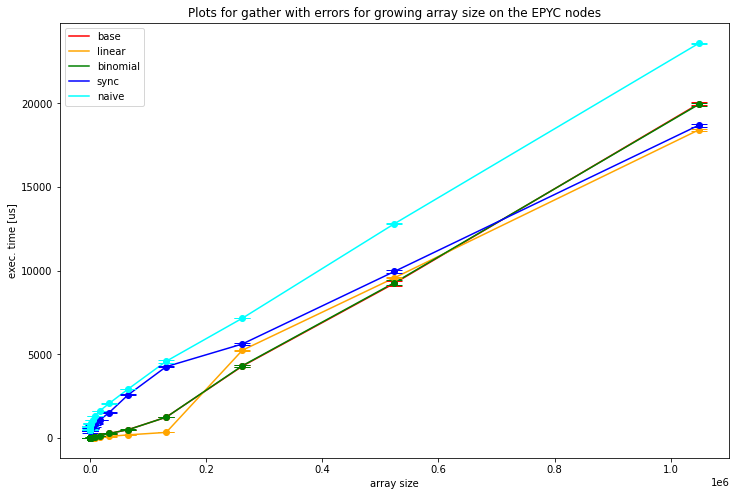

In [14]:
plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for growing array size on the EPYC nodes")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(x,trajs[0,:,0],color='red',label="base")
plt.plot(x,trajs[1,:,0],color='orange',label="linear")
plt.plot(x,trajs[2,:,0],color='green',label="binomial")
plt.plot(x,trajs[3,:,0],color='blue',label="sync")
plt.plot(x,naive_traj_EPYC[:,0],color='aqua',label="naive")
plt.errorbar(x,trajs[0,:,0],yerr=trajs[0,:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,trajs[1,:,0],yerr=trajs[1,:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,trajs[2,:,0],yerr=trajs[2,:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,trajs[3,:,0],yerr=trajs[3,:,1],fmt='o',color='blue',capsize=8)
plt.errorbar(x,naive_traj_EPYC[:,0],yerr=naive_traj_EPYC[:,1],fmt='o',color='aqua',capsize=8)
plt.legend(loc="upper left")

Also for the gather operation the situation on EPYC nodes is more articulated:

- The naive approach is again the worst performer, at least for the sizes observable in this scale. This is reassuring.
- The binomial and the base line are again performing in a very similar way and this time are superposed also for higher values. None of them is the best performer for the biggest size differentely than before. However, the gather situation and the bcast situation are very different one another, thus we cannot treat the two binomial algorithms as the same exact method. Even if, the situation was the same, the other two algorithms are not similar to the ones before, therefore it has no sense to make comparisons between the bcast and gather results.
- Thirdly, it is blatant that there is a change of position between the algorithms for very high sizes. In fact, the linear and the sync algorithm, above 0.2, have better performances than green and red, but at a certain point, the seconds start to have better results. As before, the deviations are too low to imputate this trend to some random variations.
- A particular behaviour happens in the left part of the plots where it is observable that, for the lower sizes, sync has performances as bad as the naive approach, but then the trend completely changes. Similarly, the linear algorithm is, by far, the best performer below 0.2 but then the times become worse in a very short interval.

The situation for big sizes it is quite interesting and it is difficult to decide a general best performing algorithm, for the bigger sizes, because a lot of changes take place. The lower sizes part can potentially be very interesting, therefore I will take a look now to the log10-log10 scale version of this plot. As before, I cannot report here the deviations.

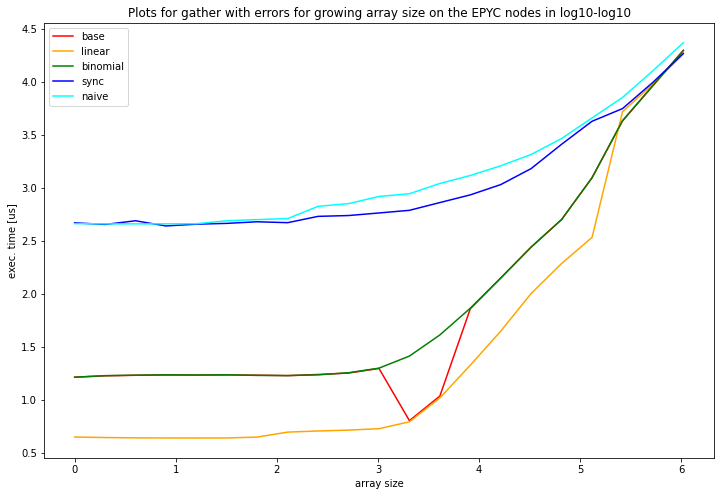

In [15]:
plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for growing array size on the EPYC nodes in log10-log10")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(np.log10(x),np.log10(trajs[0,:,0]),color='red',label="base")
plt.plot(np.log10(x),np.log10(trajs[1,:,0]),color='orange',label="linear")
plt.plot(np.log10(x),np.log10(trajs[2,:,0]),color='green',label="binomial")
plt.plot(np.log10(x),np.log10(trajs[3,:,0]),color='blue',label="sync")
plt.plot(np.log10(x),np.log10(naive_traj_EPYC[:,0]),color='aqua',label="naive")
plt.legend(loc="upper left")

Eventually the situation for smaller sizes is much more tidy than the one observed in the previous plot

- The sync and the naive trajectories are actually almost coincident in the small sizes, and only for bigger values a progressive detach of the blue line from the aqua one can be noticed. 
- The linear algorithm is actually the best in this situation, even if, its growing trend is quite strong and it becomes worse and worse for messages above the 1000 chars. 
- The binomial and the base line are actually coincident also for the small sizes, but there is this strange double step for the base line that is not actually explainable. This is probably due to some particular features of the base line method.

### THIN

Now, I will repeat these tests on the THIN nodes. As before, I will firstly import the P2P latency to obtain the naive approach. For the THIN nodes there are 48 cores, thus the operation will be measured for 48 processes.

In [16]:
x = [] #The x is the size of the message passed

#Trajs is the tensor of the 4 trajectories (base,linear,binomial and sync)
trajs = np.zeros((4,21,2),dtype=float)

for i in range(len(gather_thin_files)):
    #Each file is imported and converted to numpy format
    file = pd.read_csv(gather_thin_files[i],delimiter=",",header=None)
    file = file.to_numpy()
    
    #x is defined each time for simplicity. In each file the first columns contain the message sizes
    #thus it will be simply rewrited with the same values 4 times.
    x = file[:,0]

    #For each message size the momentums are computed
    for j in range(np.shape(file)[1]):
        trajs[i,j,0] = np.mean(file[j,1:]) #the mean
        trajs[i,j,1] = np.std(file[j,1:]) #the std

Finally, I can plot the mean times for each size for each algorithms + base line and naive approach

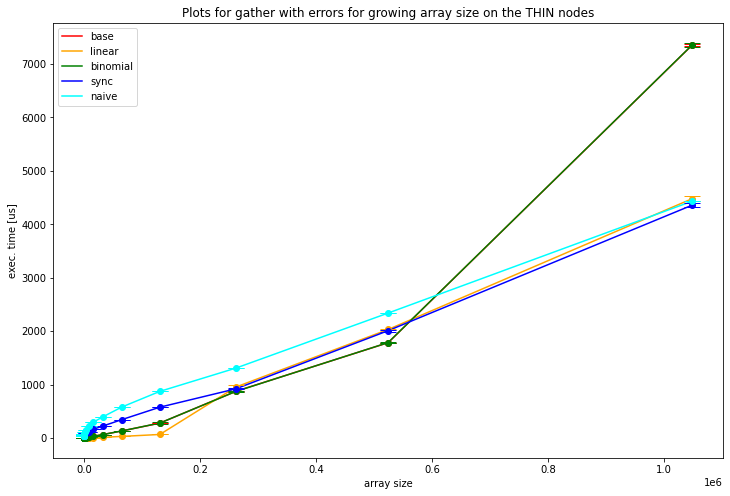

In [17]:
plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for growing array size on the THIN nodes")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(x,trajs[0,:,0],color='red',label="base")
plt.plot(x,trajs[1,:,0],color='orange',label="linear")
plt.plot(x,trajs[2,:,0],color='green',label="binomial")
plt.plot(x,trajs[3,:,0],color='blue',label="sync")
plt.plot(x,naive_traj_THIN[:,0],color='aqua',label="naive")
plt.errorbar(x,trajs[0,:,0],yerr=trajs[0,:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,trajs[1,:,0],yerr=trajs[1,:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,trajs[2,:,0],yerr=trajs[2,:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,trajs[3,:,0],yerr=trajs[3,:,1],fmt='o',color='blue',capsize=8)
plt.errorbar(x,naive_traj_THIN[:,0],yerr=naive_traj_THIN[:,1],fmt='o',color='aqua',capsize=8)
plt.legend(loc="upper left")

For the gather collective operation, the situation is quite peculiar with a lot of differences in comparison with the EPYC case.

- Starting with something similar, the extreme left part of the plot is the only one comparable. Naive above everything, linear as best performer, sync with almost naive performances then improving. Base line and binomial are almost coincident and in a intermediate situation between sync and linear.
- Moving to the right, the situation starts to change. At first, the binomial and the base line become similar to linear and sync but only for instant. Then, after a first phase where the distance between the two couples grows again, there is an enormous step for the base line - binomial couple at the biggest size. The times grow incredibly and the performances for this size become even worse than the naive approach.
- Moreover, for the biggest size, the two linear based algorithms have comparable performances with the naive approach base on an unstructured P2P communication system.

Again, the deviations are very small, therefore I can strongly affirm that the behaviours cannot be some kind of effects of stochastic fluctuations. Now, let's move to the log10-log10 plot to take a look to the smaller sizes.

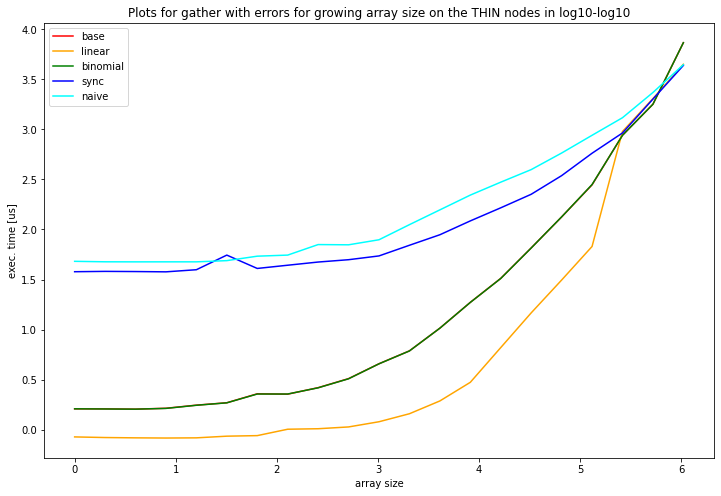

In [18]:
plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for growing array size on the THIN nodes in log10-log10")
plt.xlabel("array size")
plt.ylabel("exec. time [us]")

plt.plot(np.log10(x),np.log10(trajs[0,:,0]),color='red',label="base")
plt.plot(np.log10(x),np.log10(trajs[1,:,0]),color='orange',label="linear")
plt.plot(np.log10(x),np.log10(trajs[2,:,0]),color='green',label="binomial")
plt.plot(np.log10(x),np.log10(trajs[3,:,0]),color='blue',label="sync")
plt.plot(np.log10(x),np.log10(naive_traj_THIN[:,0]),color="aqua",label="naive")
plt.legend(loc="upper left")

For the smaller sizes, the situation is very clear, tidy and comparable with the results obtained for the EPYC nodes. 

- Until messages of 10000 chars, the linear algorithm is unconfutably the best performer, even if, for sizes above 1000, a strong growing trend appears.
- Base line and binomial are perfectly coincident in all of their trajectories for the smaller sizes.
- The sync and the naive approach for these sizes are quite near in term of values and there is a small peak in a certain point, where the sync performs worse. However, generally speaking, the sync algorithm is a bit better than the naive approach and this is reassuring. 

# VARYING NUMBER OF PROCESSES

After this analysis where I have fixed the number of processes equal to the number of cores, I will repeat the tests for both of the operations, in both of the types of nodes and for the different algorithm, looking only to times associated to the maximum size of the message but varying the number of processes. 

In every test however, I have reserved all the cores of the two nodes and then the OSU benchmarks were run with a different number of processes (-np ...). For these tests, I have always mapped the processes by node.  

## BCAST

As for the previous tests, I will start looking to the bcast collective operation and I will focus first on the results obtained on EPYC.

### EPYC

Firstly, I have to recompute the naive values for the EPYC nodes for these new tests. This time, I want to look only to the maximum size values, therefore only the last row of the file is needed. The first column is again trashed because contains the size of the messages. Obtained this file, each point of the trajectory can be computed multiplying for the number of processes. 

I want to stress an important fact. For the EPYC nodes, sampling the times with 20 runs for all the possible numbers between 2 and 256 would be too much time consuming. When there are a lot of processes, the times are becoming quite long. For this reason, I have only sample in some numbers: starting from 2, I considered the interval $[2,254]$ with 43 steps. Therefore, from a step to the next, there are 6 processes of difference. The number of processes is needed to compute the naive trajectory, thus I will define already here the $x$ values (the number of processes).

In [19]:
#Import only the last line of the P2P communication times and already compute the mean.
#I will not compute this the std because we are using only this line and then projecting it
#for the other values so in the different point the stds would be only "projections" of the original one.
file = np.mean((pd.read_csv(naive_epyc_files[0],delimiter=",",header=None).to_numpy())[-1,1:])

#Create the trajectory vector
naive_traj_EPYC = np.zeros(43,dtype=float)
#And the x values (number of processes)
x = np.linspace(2,254,43)

#Compute the values for the naive traj projecting the mean obtained above
for j in range(len(naive_traj_EPYC)):
    naive_traj_EPYC[j] = file*(x[j]-1)

This time, there are a lot of files because for each algorithm there is a file of 20 runs each for each number of processes. I will collect for all of them the mean value and the std looking to the last line of each data frame. Each mean and std is a point of the trajectory associated to its algorithm.

In [20]:
#Base line trajectory
base = np.zeros((43,2),dtype=float)

for i in range(np.shape(base)[0]):
    file = ((pd.read_csv("bcast/EPYC/Cores/base/base_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    base[i,0] = np.mean(file)
    base[i,1] = np.std(file)

In [21]:
#Pipeline trajectory
pipeline = np.zeros((43,2),dtype=float)

for i in range(np.shape(pipeline)[0]):
    file = ((pd.read_csv("bcast/EPYC/Cores/pipeline/pipeline_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    pipeline[i,0] = np.mean(file)
    pipeline[i,1] = np.std(file)

In [22]:
#Binomial trajectory
binomial = np.zeros((43,2),dtype=float)

for i in range(np.shape(binomial)[0]):
    file = ((pd.read_csv("bcast/EPYC/Cores/binomial/binomial_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    binomial[i,0] = np.mean(file)
    binomial[i,1] = np.std(file)

In [23]:
#Ring trajectory
ring = np.zeros((43,2),dtype=float)

for i in range(np.shape(ring)[0]):
    file = ((pd.read_csv("bcast/EPYC/Cores/ring/ring_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    ring[i,0] = np.mean(file)
    ring[i,1] = np.std(file)

Finally, I can plot all of them + the naive approach against the number of processes

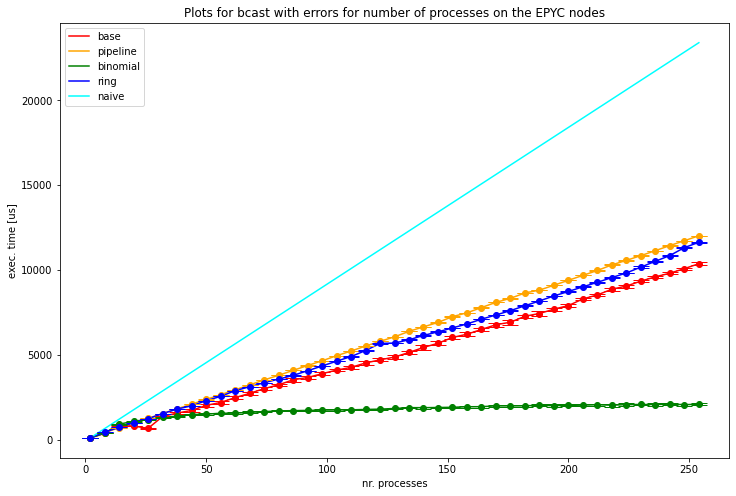

In [24]:
x = np.linspace(2,254,43)

plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for number of processes on the EPYC nodes")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,base[:,0],color='red',label="base")
plt.plot(x,pipeline[:,0],color='orange',label="pipeline")
plt.plot(x,binomial[:,0],color='green',label="binomial")
plt.plot(x,ring[:,0],color='blue',label="ring")
plt.plot(x,naive_traj_EPYC,color="aqua",label="naive")
plt.errorbar(x,base[:,0],yerr=base[:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,pipeline[:,0],yerr=pipeline[:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,binomial[:,0],yerr=binomial[:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,ring[:,0],yerr=ring[:,1],fmt='o',color='blue',capsize=8)
plt.legend(loc="upper left")

The situation this time is well defined and there are some similarities with the analysis for different sizes.

- Firstly, the naive approach, at least for the numbers of processes observable clearly in this plot, is by far the worst performer with an important distance from all the others. 
- The binomial algorithm is the best performer on the EPYC nodes also in term of number of processes which is not an obvious result. Moreover, the scalability of this algorithm for a growing number of processes is even better showing very small differences from a step to another.
- The base, the pipeline and the ring have very comparable performances, with the pipeline algorithm always the worst of the three and the base versione the best one. The differences between these three become wider for a major number of processes, but, the results are still comparable.

In this plot is difficult to appreciate and observe the situation for very small numbers of processes, therefore I will produce the log10 version of the plot. However, having a small $x$ axis, I will only scale with log10 the execution time.

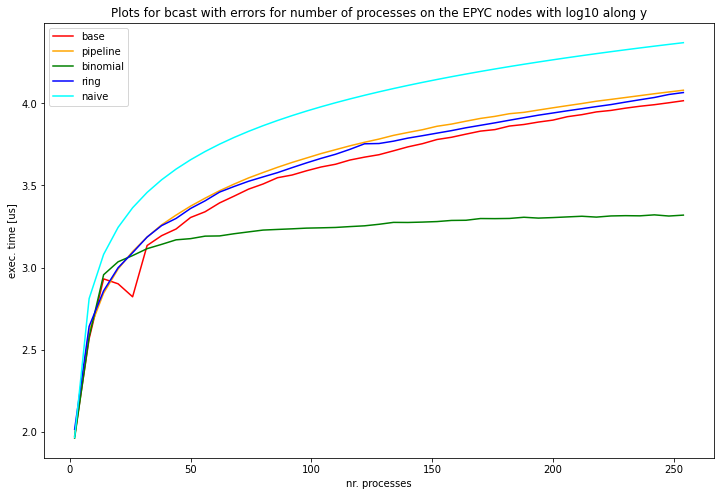

In [25]:
plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for number of processes on the EPYC nodes with log10 along y")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,np.log10(base[:,0]),color='red',label="base")
plt.plot(x,np.log10(pipeline[:,0]),color='orange',label="pipeline")
plt.plot(x,np.log10(binomial[:,0]),color='green',label="binomial")
plt.plot(x,np.log10(ring[:,0]),color='blue',label="ring")
plt.plot(x,np.log10(naive_traj_EPYC),color="aqua",label="naive")
plt.legend(loc="upper left")

For a small number of processes, there are similar times for almost all the algorithms.

- Generally speaking, binomial is no more the best performer, if the processes are below 25 c.a., and at least one of the other algorithms is a better performer in some cases.
- The base line presents a strange downward phase not so explainable.
- However, for very few processes, the approaches present almost the same results, thus choosing one instead of another makes no differences.

### THIN

Moving now to the THIN nodes, I have again to re-import and elaborate the time values of the P2P communications for the naive approach. In the THIN nodes, having only 48 cores, I have sampled for all the algorithms, of both bcast and gather, at every number of processes between 2 and 48. It will be theoretically not necessary to define here the $x$ because the conversion is more simple, but, for symmetry, I will define $x$ again and use it to compute the naive trajectory. 

In [26]:
#Import only the last line of the P2P communication times and already compute the mean.
#I will not compute this the std because we are using only this line and then projecting it
#for the other values so in the different point the stds would be only "projections" of the original one.
file = np.mean((pd.read_csv(naive_thin_files[0],delimiter=",",header=None).to_numpy())[-1,1:])

#Create the trajectory vector
naive_traj_THIN = np.zeros(47,dtype=float)
#And the x values (number of processes)
x = np.linspace(2,48,47)

#Compute the values for the naive traj projecting the mean obtained above
for j in range(len(naive_traj_THIN)):
    naive_traj_THIN[j] = file*(x[j]-1)

Again, there are a lot of files because for each algorithm because there is a file of 20 runs each for each number of processes. I will collect for all of them the mean value and the std looking to the last line of each data frame. Each mean and std is a point of the trajectory associated to its algorithm.

In [27]:
#Base line trajectory
base = np.zeros((47,2),dtype=float)

for i in range(np.shape(base)[0]):
    file = ((pd.read_csv("bcast/THIN/Cores/base/base_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    base[i,0] = np.mean(file)
    base[i,1] = np.std(file)

In [28]:
#Pipeline trajectory
pipeline = np.zeros((47,2),dtype=float)

for i in range(np.shape(pipeline)[0]):
    file = ((pd.read_csv("bcast/THIN/Cores/pipeline/pipeline_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    pipeline[i,0] = np.mean(file)
    pipeline[i,1] = np.std(file)

In [29]:
#Binomial trajectory
binomial = np.zeros((47,2),dtype=float)

for i in range(np.shape(binomial)[0]):
    file = ((pd.read_csv("bcast/THIN/Cores/binomial/binomial_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    binomial[i,0] = np.mean(file)
    binomial[i,1] = np.std(file)

In [30]:
#Ring trajectory
ring = np.zeros((47,2),dtype=float)

for i in range(np.shape(ring)[0]):
    file = ((pd.read_csv("bcast/THIN/Cores/ring/ring_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    ring[i,0] = np.mean(file)
    ring[i,1] = np.std(file)

Finally, I can plot all of them + the naive approach against the number of processes

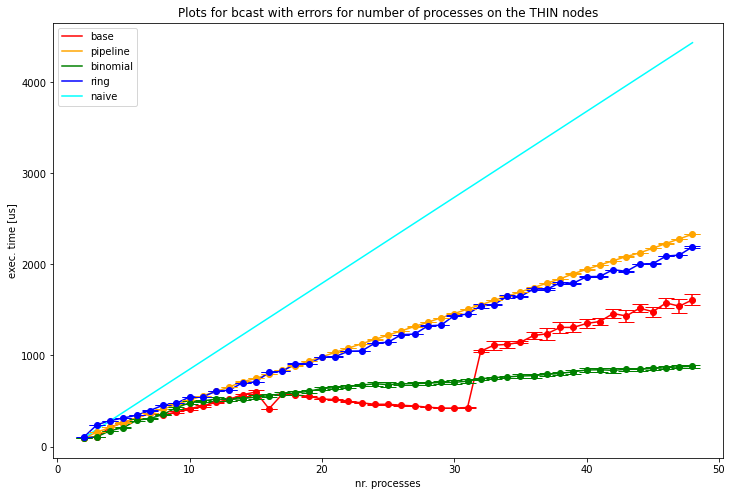

In [31]:
x = np.linspace(2,48,47)

plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for number of processes on the THIN nodes")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,base[:,0],color='red',label="base")
plt.plot(x,pipeline[:,0],color='orange',label="pipeline")
plt.plot(x,binomial[:,0],color='green',label="binomial")
plt.plot(x,ring[:,0],color='blue',label="ring")
plt.plot(x,naive_traj_THIN,color="aqua",label="naive")
plt.errorbar(x,base[:,0],yerr=base[:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,pipeline[:,0],yerr=pipeline[:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,binomial[:,0],yerr=binomial[:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,ring[:,0],yerr=ring[:,1],fmt='o',color='blue',capsize=8)
plt.legend(loc="upper left")

For the THIN nodes, the situation is a bit more complicate then the EPYC one:

- Reassuringly, the naive approach is still the worst performer, at least for the sizes appreciable at this scale.
- As for the EPYC nodes, the ring and the pipeline algorithms have very similar and comparable performances.
- The binomial algorithm still presents its good scalability, but this time is not always the best performer. In fact, the base line is no more the intermediate trajectory between the ring and the binomial algorithm. It is clearly noticeable that the base solution, after a growing phase, starts to shrink its times until a number of processes of 32. Here the base presents a step and the times augment drastically moving the trajectory to a position similar to the EPYC case. Clearly in the base version there is a change of algorithm or an important variation in the method for more than 32 processes.

Again, in all the cases the deviations are too low to be a justification of the behaviours. Let's move to the smaller number of processes looking to the semi-log10 plot.

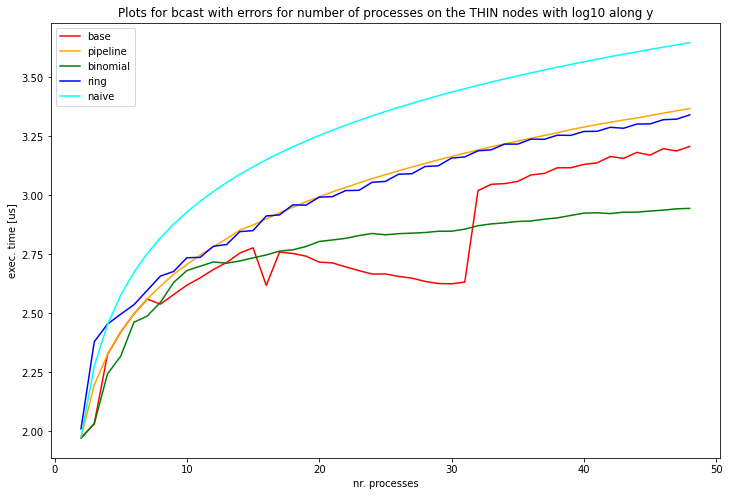

In [32]:
plt.figure(figsize=(12,8))
plt.title("Plots for bcast with errors for number of processes on the THIN nodes with log10 along y")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,np.log10(base[:,0]),color='red',label="base")
plt.plot(x,np.log10(pipeline[:,0]),color='orange',label="pipeline")
plt.plot(x,np.log10(binomial[:,0]),color='green',label="binomial")
plt.plot(x,np.log10(ring[:,0]),color='blue',label="ring")
plt.plot(x,np.log10(naive_traj_THIN),color="aqua",label="naive")
plt.legend(loc="upper left")

Looking below the 10 processe, the relationships between the trajectories are quite chaotic. There are a lot of inteserctions between the lines, therefore it will be cumbersome to analyse every single situation. However, we can see that all the algorithms have comparable initial values.

## GATHER

Let's move on to the other collective operation now. As for bcast, I will analyse first the results for the EPYC nodes.

### EPYC

This time, it is not necessary to recompute the naive trajectory because I can simply use the one computed for the bcast being conceptually the same. I can directly move to import the files and obtain the statistical momentums for the base line and the three gather algorithms: linear, binomial and sync.

In [33]:
#Base line trajectory
base = np.zeros((43,2),dtype=float)

for i in range(np.shape(base)[0]):
    file = ((pd.read_csv("gather/EPYC/Cores/base/base_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    base[i,0] = np.mean(file)
    base[i,1] = np.std(file)

In [34]:
#linear trajectory
linear = np.zeros((43,2),dtype=float)

for i in range(np.shape(linear)[0]):
    file = ((pd.read_csv("gather/EPYC/Cores/linear/linear_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    linear[i,0] = np.mean(file)
    linear[i,1] = np.std(file)

In [35]:
#binomial trajectory
binomial = np.zeros((43,2),dtype=float)

for i in range(np.shape(binomial)[0]):
    file = ((pd.read_csv("gather/EPYC/Cores/binomial/binomial_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    binomial[i,0] = np.mean(file)
    binomial[i,1] = np.std(file)

In [36]:
#sync trajectory
sync = np.zeros((43,2),dtype=float)

for i in range(np.shape(sync)[0]):
    file = ((pd.read_csv("gather/EPYC/Cores/sync/sync_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    sync[i,0] = np.mean(file)
    sync[i,1] = np.std(file)

And now, let's plot all of these + the naive approach

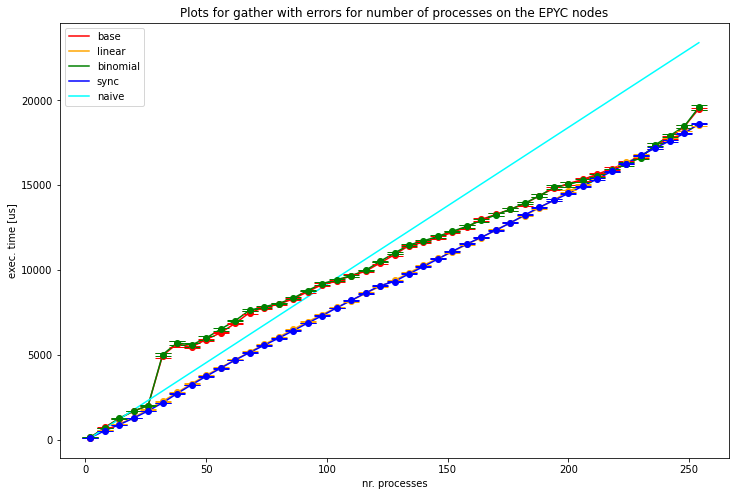

In [37]:
x = np.linspace(2,254,43)

plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for number of processes on the EPYC nodes")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,base[:,0],color='red',label="base")
plt.plot(x,linear[:,0],color='orange',label="linear")
plt.plot(x,binomial[:,0],color='green',label="binomial")
plt.plot(x,sync[:,0],color='blue',label="sync")
plt.plot(x,naive_traj_EPYC,color="aqua",label="naive")
plt.errorbar(x,base[:,0],yerr=base[:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,linear[:,0],yerr=linear[:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,binomial[:,0],yerr=binomial[:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,sync[:,0],yerr=sync[:,1],fmt='o',color='blue',capsize=8)
plt.legend(loc="upper left")

The gather results presents very different behaviours than the trajectories of the bcast collective operation. I can spot some differences:

- Before focusing on the specific algorithms, I want to highlight that the performances for the gather operation do not improve so much using the different algorithms in comparison with a gather approach based on P2P unstructured communications. In fact, above 100 processes, there are some gains in comparison with the naive even if are relative smaller than the time differences between the algorithms and the naive found for the bcast.
- This lesser distance between the algorithms and the naive approach leads to have a certain region where the binomial and the base line, after a jump around 25 processes, perform even worse than the naive approach. Fortunately, above 100 processes, these structured ways are able to perform again better than the naive.
- The linear and the sync algorithms perform very similarly with a perfect superposition of the points. It is also appreciable the steady growing linear regime of the times that presents no aberrations or strange fluctuations. 
- For a number of processes above 200, the algorithms and the base version perform almost identically. However, for 254, it is noticeable again better performances for the linear and the sync algorithm. 

Once again, the fluctuations are to small to imputate them as the cause of the behaviours. Let's look now for smaller numbers of processes in the semi-log10 plot.

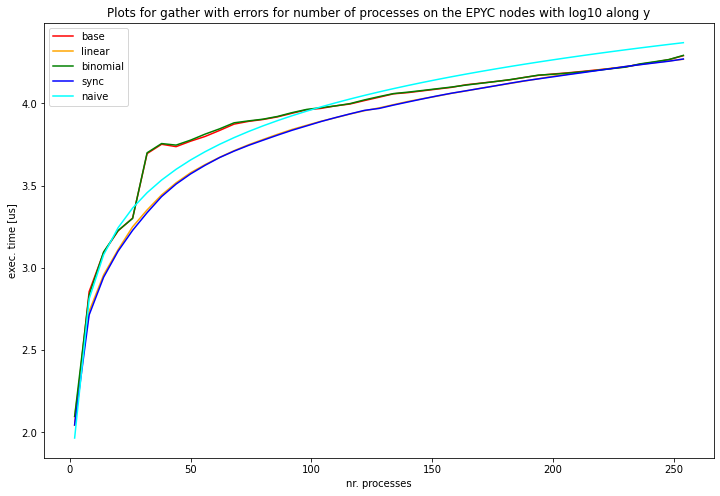

In [38]:
plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for number of processes on the EPYC nodes with log10 along y")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,np.log10(base[:,0]),color='red',label="base")
plt.plot(x,np.log10(linear[:,0]),color='orange',label="linear")
plt.plot(x,np.log10(binomial[:,0]),color='green',label="binomial")
plt.plot(x,np.log10(sync[:,0]),color='blue',label="sync")
plt.plot(x,np.log10(naive_traj_EPYC),color="aqua",label="naive")
plt.legend(loc="upper left")

Looking below 50 processes, the situation is very convergent. Before the step that pushes binomial and base line above the naive approach, the two algorithms are very similar to the naive approach in term of performances. Moving down, the distance between these and the two linear versions shrinks and the choice of an algorithm or another is indifferent.

### THIN

Let's do this again in the THIN nodes. I have not to import again the naive data or elaborate them in a different way because I can recycle the values computed before for the bcast. I can directly move to import the files and obtain the statistical momentums for the base line and the three gather algorithms.

In [39]:
#Base line trajectory
base = np.zeros((47,2),dtype=float)

for i in range(np.shape(base)[0]):
    file = ((pd.read_csv("gather/THIN/Cores/base/base_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    base[i,0] = np.mean(file)
    base[i,1] = np.std(file)

In [40]:
#Linear trajectory
linear = np.zeros((47,2),dtype=float)

for i in range(np.shape(linear)[0]):
    file = ((pd.read_csv("gather/THIN/Cores/linear/linear_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    linear[i,0] = np.mean(file)
    linear[i,1] = np.std(file)

In [41]:
#Binomial trajectory
binomial = np.zeros((47,2),dtype=float)

for i in range(np.shape(binomial)[0]):
    file = ((pd.read_csv("gather/THIN/Cores/binomial/binomial_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    binomial[i,0] = np.mean(file)
    binomial[i,1] = np.std(file)

In [42]:
#Sync trajectory
sync = np.zeros((47,2),dtype=float)

for i in range(np.shape(sync)[0]):
    file = ((pd.read_csv("gather/THIN/Cores/sync/sync_"+str(i+2)+".csv",delimiter=",",header=None).iloc[-1]).to_numpy())[1:]
    sync[i,0] = np.mean(file)
    sync[i,1] = np.std(file)

Finally, I can plot all of them + the naive approach against the number of processes

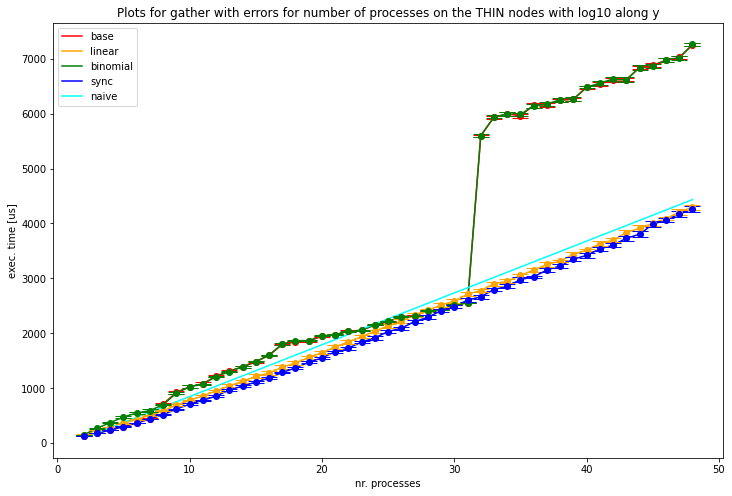

In [43]:
x = np.linspace(2,48,47)

plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for number of processes on the THIN nodes with log10 along y")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,base[:,0],color='red',label="base")
plt.plot(x,linear[:,0],color='orange',label="linear")
plt.plot(x,binomial[:,0],color='green',label="binomial")
plt.plot(x,sync[:,0],color='blue',label="sync")
plt.plot(x,naive_traj_THIN,color="aqua",label="naive")
plt.errorbar(x,base[:,0],yerr=base[:,1],fmt='o',color='red',capsize=8)
plt.errorbar(x,linear[:,0],yerr=linear[:,1],fmt='o',color='orange',capsize=8)
plt.errorbar(x,binomial[:,0],yerr=binomial[:,1],fmt='o',color='green',capsize=8)
plt.errorbar(x,sync[:,0],yerr=sync[:,1],fmt='o',color='blue',capsize=8)
plt.legend(loc="upper left")

Looking back the plots of the EPYC node, I want to highlight that this plot seems almost as a truncation (a chunk) of the previous one cutting at 50 processes. For the bcast operation, there are important differences between the EPYCs and THINs, but here, the results seem truly the truncation of the EPYC plot to 50 processes. This is actually not a bad thing: it tells us that the gather operation on the THIN node feels only a little the structural differences between the two types of node. However, in this plot there are some things to notice:

- The step at 32 processes characterise both the base line and the binomial. There probably is a certain radical change in the algorithms or sub-methods of these two trajectories when this limit is passed. At this scale, there is also another region, between 10 and 20 processes, where these two perform again worse than the naive approach.
- The linear and the sync have comparable performances, even if, the sync seems to be a bit better than the simple linear version. The two have better times than the naive approach, but the distance between them and the one based on the unstructured P2P communications becomes smaller for fewer processes.

Let's try to develop the region with less than 10 processes passing to the semi-log10 plot.

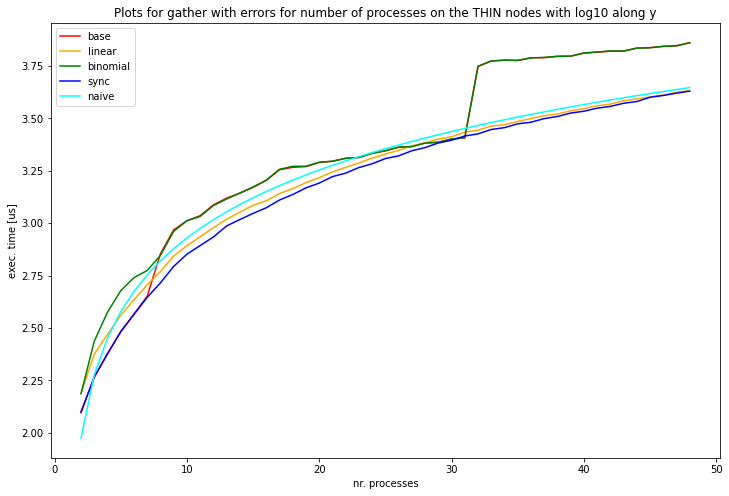

In [44]:
plt.figure(figsize=(12,8))
plt.title("Plots for gather with errors for number of processes on the THIN nodes with log10 along y")
plt.xlabel("nr. processes")
plt.ylabel("exec. time [us]")

plt.plot(x,np.log10(base[:,0]),color='red',label="base")
plt.plot(x,np.log10(linear[:,0]),color='orange',label="linear")
plt.plot(x,np.log10(binomial[:,0]),color='green',label="binomial")
plt.plot(x,np.log10(sync[:,0]),color='blue',label="sync")
plt.plot(x,np.log10(naive_traj_THIN),color="aqua",label="naive")
plt.legend(loc="upper left")

Below 10 processes the situation is a bit messy. There are a lot of intesections and it is quite difficult to find a better performer in all of the situations.